# Ajuste de la curva de luz del telescopio OGLE
En este notebook se ajusta la curva de luz del telescopio OGLE. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


class fuente_puntual(object):

    def __init__(self, fichero):
        self.dat = np.loadtxt(fichero)
        self.dic = {'t':self.dat[:,0], 'I':self.dat[:,1], 'Ierr':self.dat[:,2],'t0':2450000}
    
    #implementamos función modelo que quede bien
    def model_I(self,t,I0,y0,t0,tE):
        y=np.sqrt(y0**2+((t-t0)/tE)**2)
        res=I0-2.5*np.log10((y**2+2)/(y*(np.sqrt(y**2+4))))
        return res
    
    def plot(self,params):
        plt.rcParams['figure.figsize'] = (7.0,5.0)
        plt.errorbar(self.dic['t'],self.dic['I'], yerr=self.dic['Ierr'], fmt='.')
        plt.xlabel('HJD - '+str(self.dic['t0']), fontsize=14)
        plt.ylabel('Magnitud I', fontsize=14)
        plt.gca().invert_yaxis()
        paramnames=['I0', 'y0', 't0', 'tE']
        param_labels=[r'$I_0$',r'$y0$', r'$t_{0}$', r'$t_E$']
        tgrid=np.linspace(self.dic['t'].min(), self.dic['t'].max(), 1000)
        plt.plot(tgrid, self.model_I(tgrid, **params),label='modelo', zorder=2)
        plt.legend()
        
    def plotraw(self):
        plt.rcParams['figure.figsize'] = (7.0,5.0)
        plt.errorbar(self.dic['t'],self.dic['I'], yerr=self.dic['Ierr'], fmt='.')
        plt.xlabel('HJD - '+str(self.dic['t0']), fontsize=14)
        plt.ylabel('Magnitud I', fontsize=14)
        plt.gca().invert_yaxis()


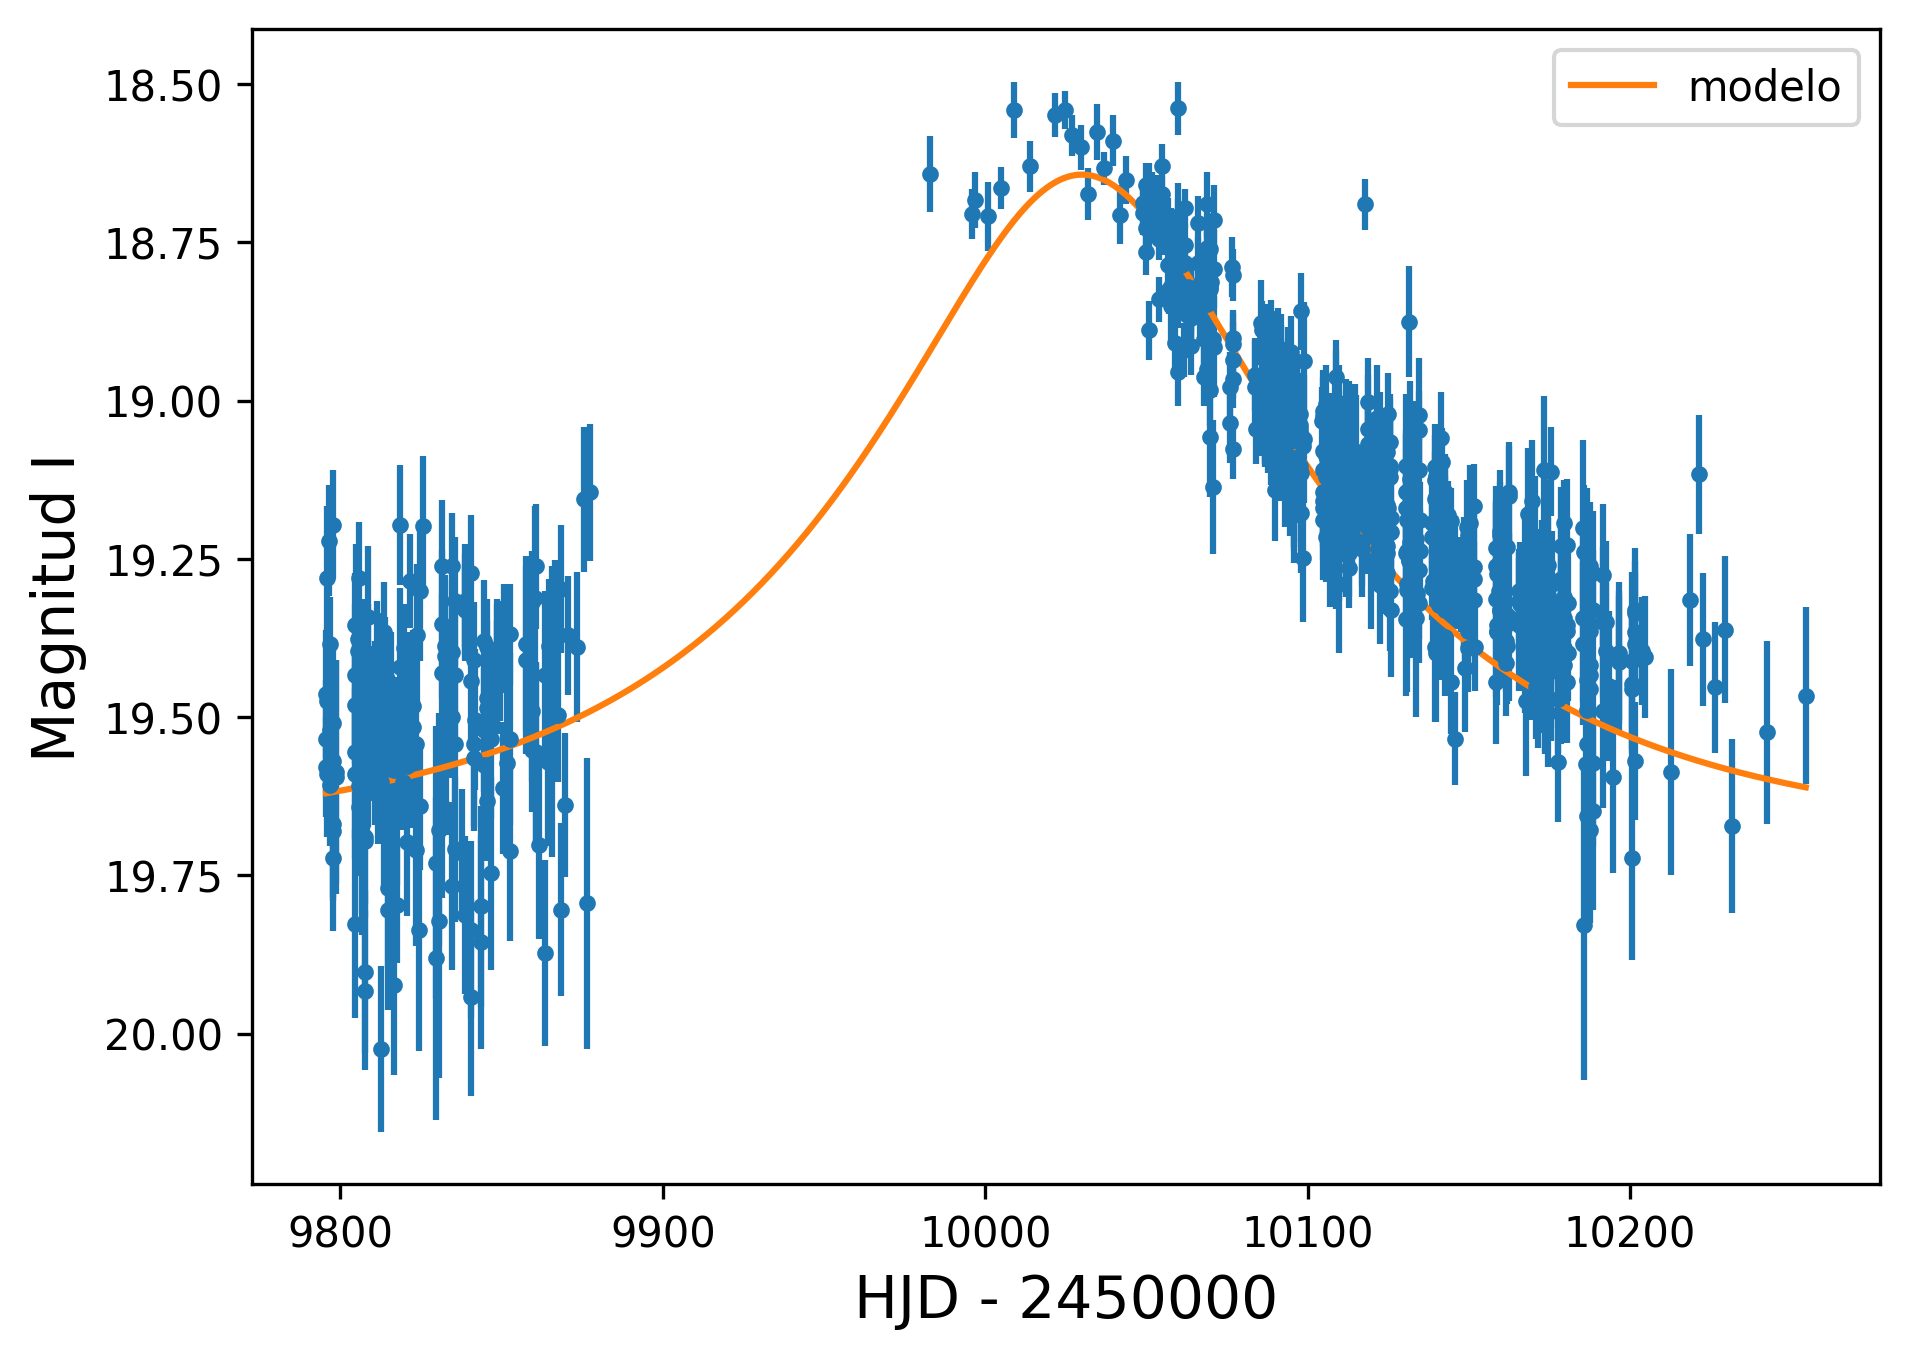

In [13]:
#UTILIZO OGLE-2023-BLG-0011 https://ogle.astrouw.edu.pl/ogle4/ews/2023/blg-0011.html
fuente = fuente_puntual('phot2023.dat')
fuente.dic['t'] -= fuente.dic['t0']
params={'I0':19.70, 'y0':0.40, 't0':10030, 'tE':130} #haciendo prueba y error llegamos a esto
fuente.plot(params)
plt.savefig('ajusteamano2023')

In [4]:
#EMPEZAMOS AJUSTANDO MEJOR EL MODELO PARA ELLO USAMOS LMFIT
import lmfit

#valores iniciales para el parametro (el flujo viene dado en magnitud I: mref-2,5log(F/Fref))
p=lmfit.Parameters()
p.add_many(('t0',10030,True,9900,10200), ('tE',130,True,1.,250),('y0',0.40,True,0.01,1.0),('I0',19.70,True,19,21))
shape=np.array(np.shape(fuente.dat))
i=i=np.linspace(0,shape[0]-1,shape[0],dtype='int')
def coste(p):
    paramsnew={'I0':p['I0'], 'y0':p['y0'], 't0':p['t0'], 'tE':p['tE']}
    res=np.ndarray(shape[0])
    for i in range(shape[0]):
        res[i]=((fuente.model_I(fuente.dic['t'][i],**paramsnew)-fuente.dic['I'][i])/(fuente.dic['Ierr'][i]))
    return res
#hay que minimizar el coste (hay mas de un algoritmo) aqui usamos NELDER-MEAD optimizacion
mi = lmfit.minimize(coste,p,method='Nelder')
mi.params




name,value,initial value,min,max,vary
t0,10020.7408,10030,9900.00000,10200.0000,True
tE,146.306730,130,1.00000000,250.000000,True
y0,0.42248163,0.4,0.01000000,1.00000000,True
I0,19.6215478,19.7,19.0000000,21.0000000,True


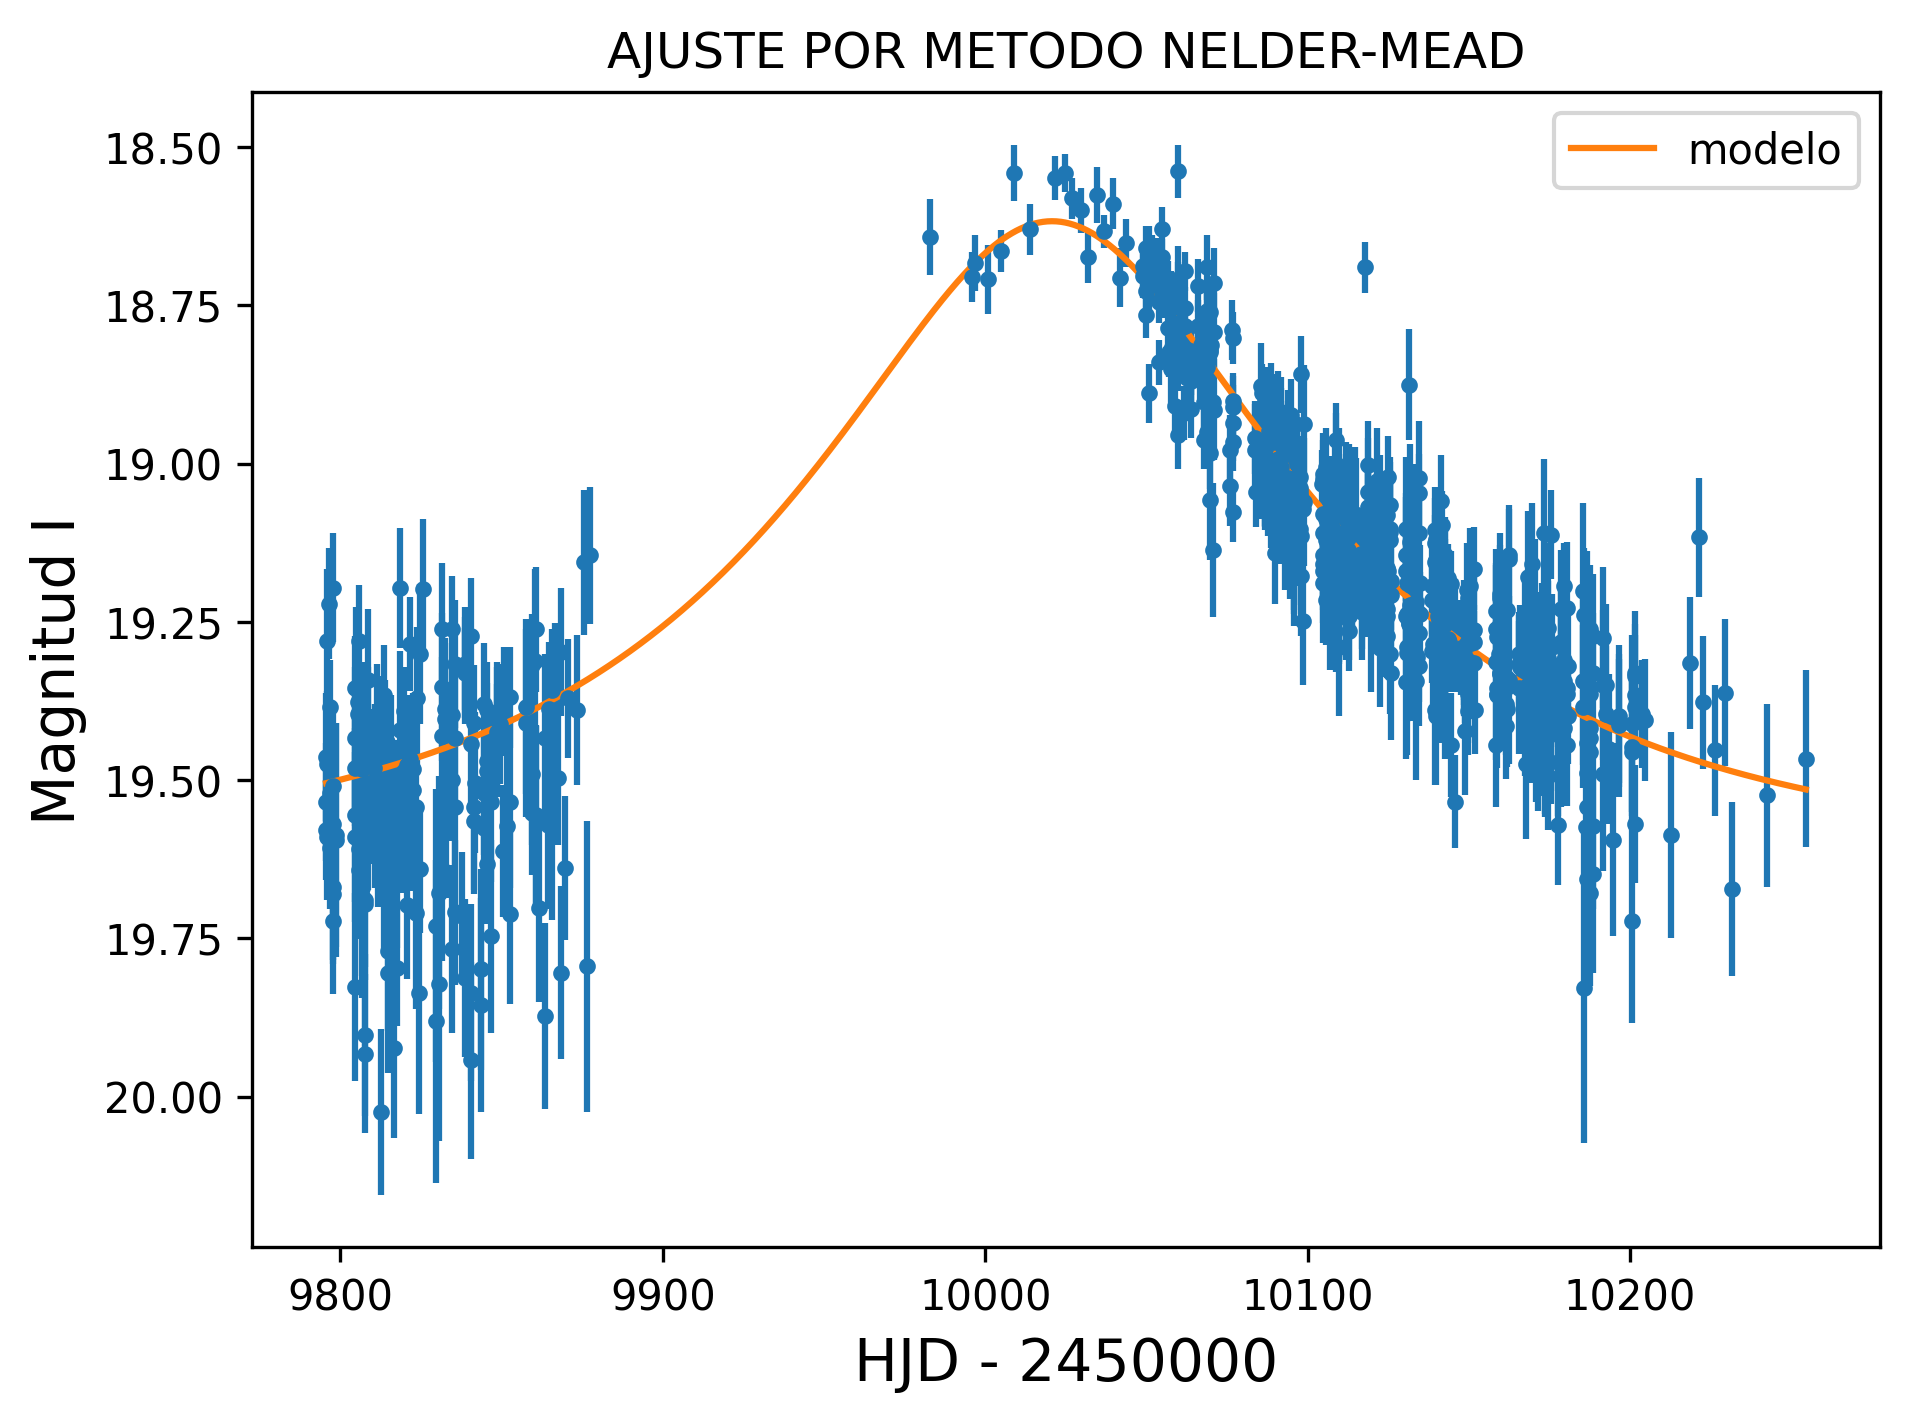

In [5]:
pN=mi.params
paramsN={'I0':pN['I0'], 'y0':pN['y0'], 't0':pN['t0'], 'tE':pN['tE']}
plt.title('AJUSTE POR METODO NELDER-MEAD')
fuente.plot(paramsN)
plt.savefig('Nelder')

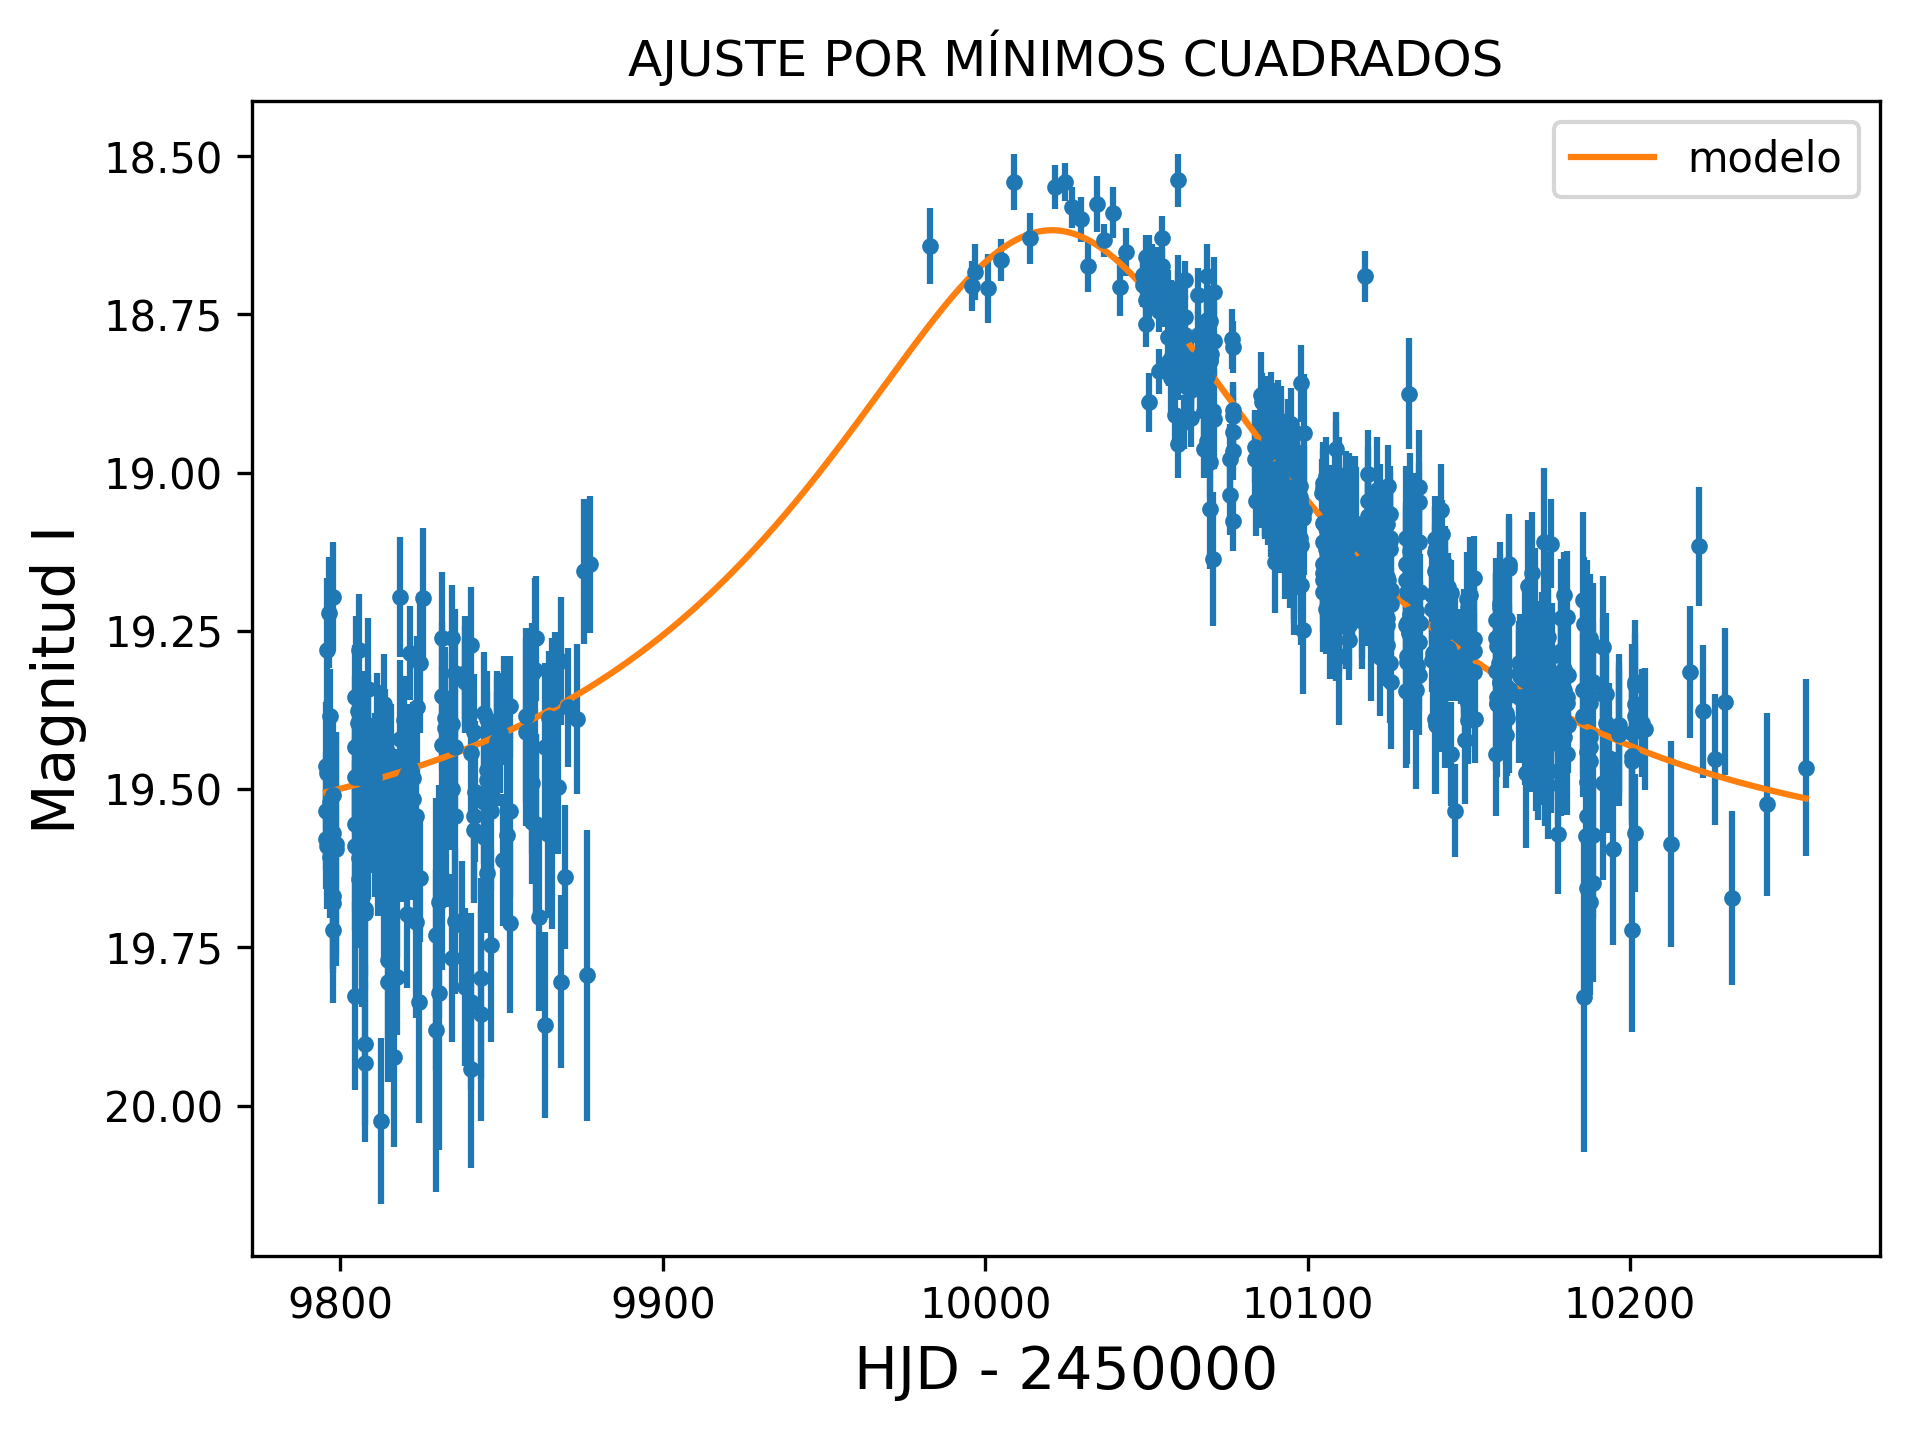

In [6]:
mi2=lmfit.minimize(coste,p,method='leastsq')
plq=mi2.params
paramslq={'I0':plq['I0'], 'y0':plq['y0'], 't0':plq['t0'], 'tE':plq['tE']}
plt.title('AJUSTE POR MÍNIMOS CUADRADOS')
fuente.plot(paramslq)
plt.savefig('lq')

In [9]:
mi2.params

name,value,standard error,relative error,initial value,min,max,vary
t0,10020.7418,1.98501069,(0.02%),10030,9900.00000,10200.0000,True
tE,146.302777,9.26203067,(6.33%),130,1.00000000,250.000000,True
y0,0.42248639,0.01400221,(3.31%),0.4,0.01000000,1.00000000,True
I0,19.6215369,0.02821205,(0.14%),19.7,19.0000000,21.0000000,True
